In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import itertools
from itertools import zip_longest
from collections import Counter
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from itertools import zip_longest

In [ ]:
# Define the path to your local CSV file
csv_path = Path(r"C:Local_folder") / "df_unique.csv"

# Load the CSV into a DataFrame
df_unique = pd.read_csv(csv_path)
df_unique.head()

Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'scale_pos_weight': 1}
XGBoost best threshold: 0.83
                    Accuracy  F1-Score
LogisticRegression  0.762828  0.485437
RandomForest        0.860382  0.462855
DecisionTree        0.814087  0.387345
XGBoost             0.845954  0.525480


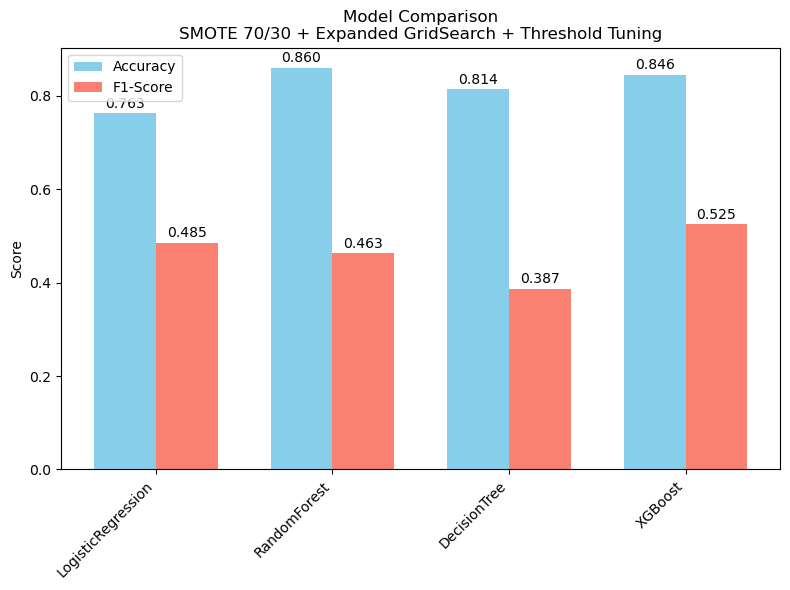

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# 1) Prepare the DataFrame
df = df_unique.copy()
drop_cols = [c for c in df.columns if "_id" in c or c in ["subject_id", "diag_seq_nums"]]
df.drop(columns=drop_cols, errors="ignore", inplace=True)

num_features = [
    "n_lab_events",
    "n_icd_procs",
    "n_med_admin_events",
    "icu_stays",
    "n_hcpcs_events",
    "Weight",
    "time_in_hospital"
]

cat_features = ["insurance", "discharge_location", "meds_admin", "admission_type"]

X = df[num_features + cat_features]
y = df["outcome_aki"]

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3) Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
])
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# 4) Manual SMOTE-style 70/30 oversampling
arr = y_train.to_numpy()
idx0 = np.where(arr == 0)[0]
idx1 = np.where(arr == 1)[0]
n0   = len(idx0)
n1_up= int(n0 * (0.7/0.3))
rng  = np.random.RandomState(42)
idx1_up = rng.choice(idx1, size=n1_up, replace=True)
idx_res = np.concatenate([idx0, idx1_up])
rng.shuffle(idx_res)
X_res, y_res = X_train_proc[idx_res], arr[idx_res]

# 5) GridSearchCV on XGBoost (expanded)
xgb = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)
xgb_param_grid = {
    "n_estimators":   [50, 100, 150],
    "max_depth":      [3, 5, 7],
    "learning_rate":  [0.01, 0.05, 0.1],
    "scale_pos_weight":[1, len(y_res[y_res==0]) / len(y_res[y_res==1])]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, scoring="f1", cv=3, n_jobs=-1)
xgb_grid.fit(X_res, y_res)
best_xgb = xgb_grid.best_estimator_

# 6) Threshold tuning for XGBoost
proba = best_xgb.predict_proba(X_test_proc)[:,1]
best_thr, best_f1, best_acc = 0.5, 0, 0
for thr in np.linspace(0.1, 0.9, 81):
    p   = (proba >= thr).astype(int)
    f1  = f1_score(y_test, p)
    acc = accuracy_score(y_test, p)
    if min(f1, acc) > min(best_f1, best_acc):
        best_f1, best_acc, best_thr = f1, acc, thr

# 7) Train the other models
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=-1),
    "RandomForest":       RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1),
    "DecisionTree":       DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "XGBoost":            best_xgb
}

results = {}
for name, model in models.items():
    if name != "XGBoost":
        model.fit(X_res, y_res)
        preds = model.predict(X_test_proc)
    else:
        preds = (best_xgb.predict_proba(X_test_proc)[:,1] >= best_thr).astype(int)
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1-Score": f1_score(y_test, preds)
    }

# 8) Display and plot
results_df = pd.DataFrame(results).T
print("Best XGBoost params:", xgb_grid.best_params_)
print(f"XGBoost best threshold: {best_thr:.2f}")
print(results_df)

names = results_df.index.tolist()
accs  = results_df["Accuracy"].tolist()
f1s   = results_df["F1-Score"].tolist()
x = np.arange(len(names))
w = 0.35

fig, ax = plt.subplots(figsize=(8,6))
bars1 = ax.bar(x - w/2, accs, w, label="Accuracy", color="skyblue")
bars2 = ax.bar(x + w/2, f1s,  w, label="F1-Score", color="salmon")
for grp in (bars1, bars2):
    for bar in grp:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, h+0.005, f"{h:.3f}", ha="center", va="bottom")

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Comparison\nSMOTE 70/30 + Expanded GridSearch + Threshold Tuning")
ax.legend()
plt.tight_layout()
plt.show()


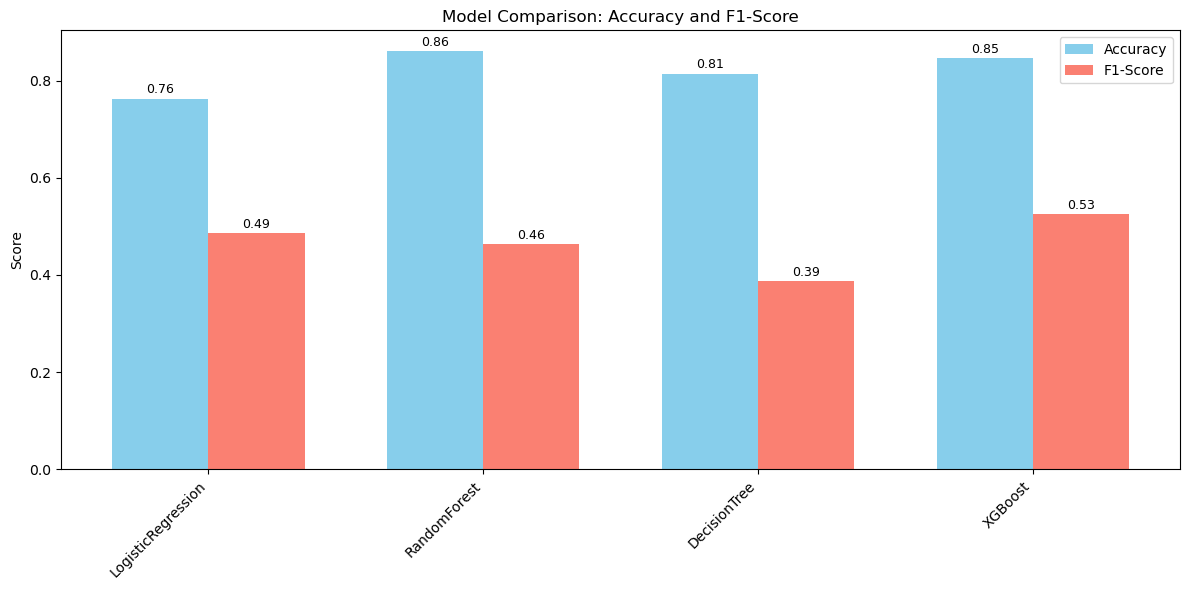

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results_df is already in the environment
model_names = results_df.index.tolist()
acc_vals    = results_df['Accuracy'].tolist()
f1_vals     = results_df['F1-Score'].tolist()

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars_acc = ax.bar(x - width/2, acc_vals, width, label='Accuracy', color='skyblue')
bars_f1  = ax.bar(x + width/2, f1_vals,  width, label='F1-Score', color='salmon')

for bar in bars_acc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

for bar in bars_f1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy and F1-Score')
ax.legend()
plt.tight_layout()
plt.show()


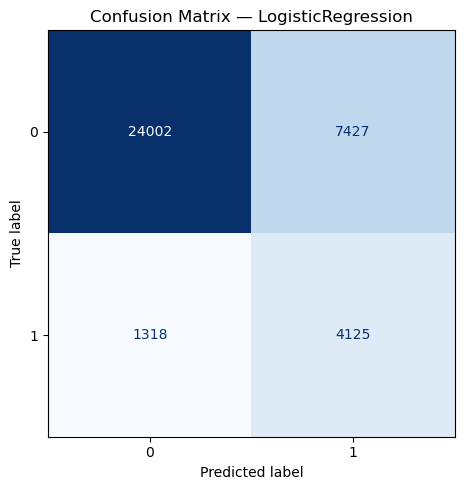

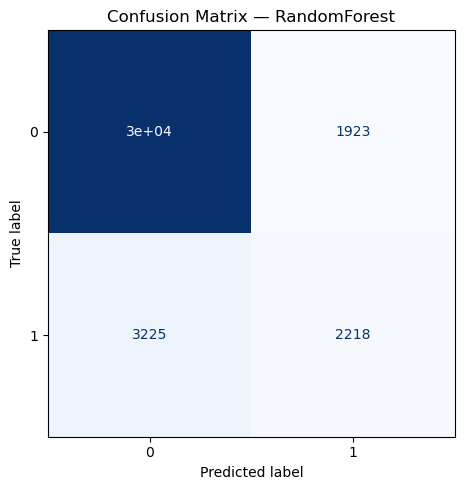

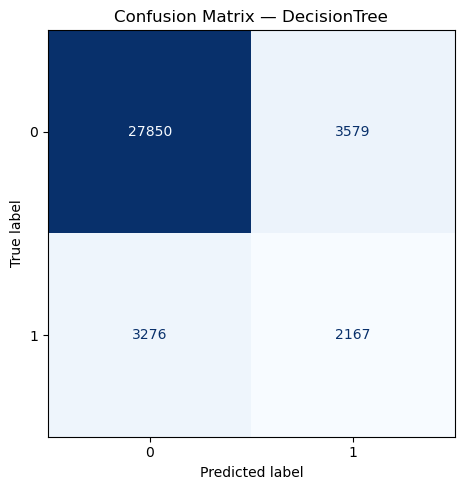

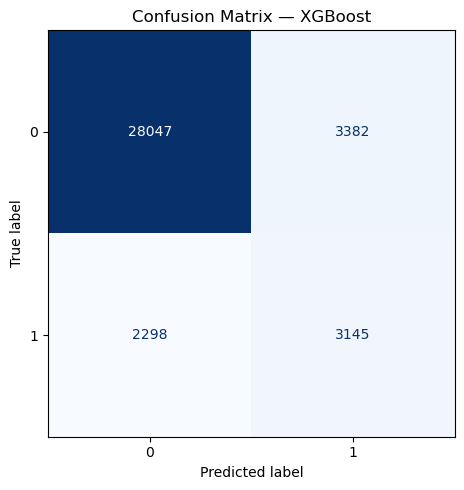

In [79]:
# ————— Confusion Matrices —————
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    if name == "XGBoost":
        probs = best_xgb.predict_proba(X_test_proc)[:, 1]
        y_pred = (probs >= best_thr).astype(int)
    else:
        y_pred = model.predict(X_test_proc)
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

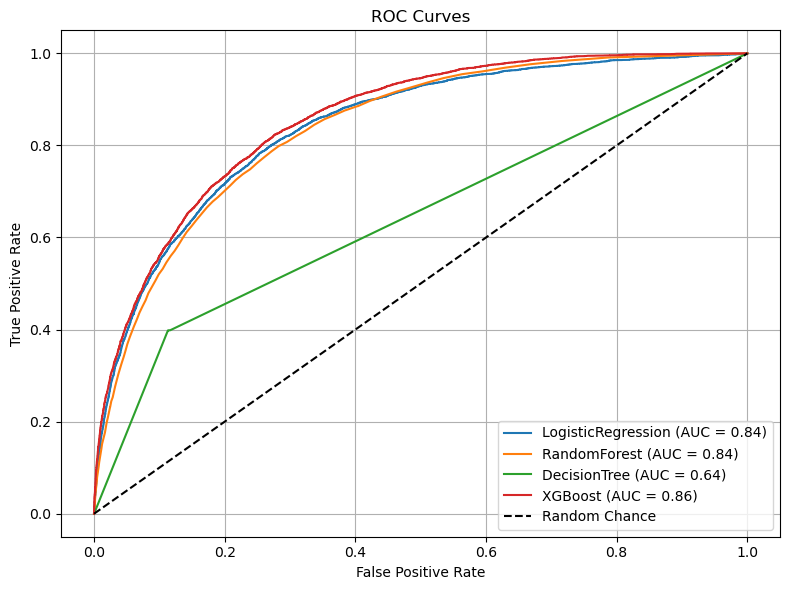

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # get a continuous score for each model
    if name == "XGBoost":
        # use the tuned XGBoost probabilities
        y_score = best_xgb.predict_proba(X_test_proc)[:, 1]
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_proc)[:, 1]
    else:
        y_score = model.decision_function(X_test_proc)
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


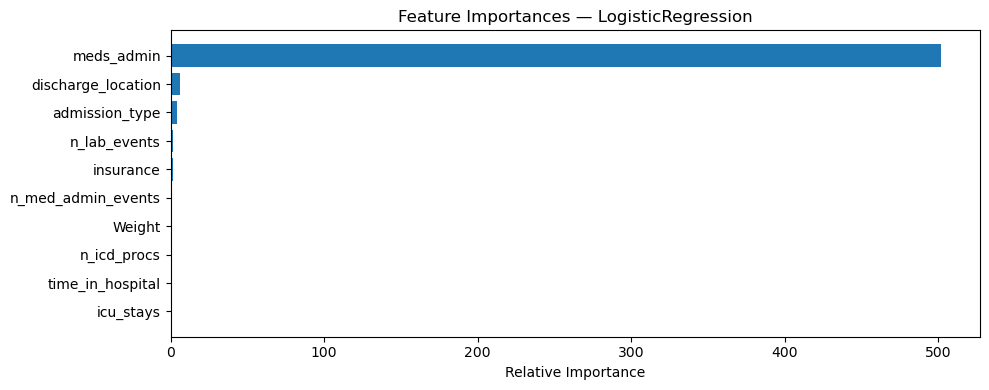

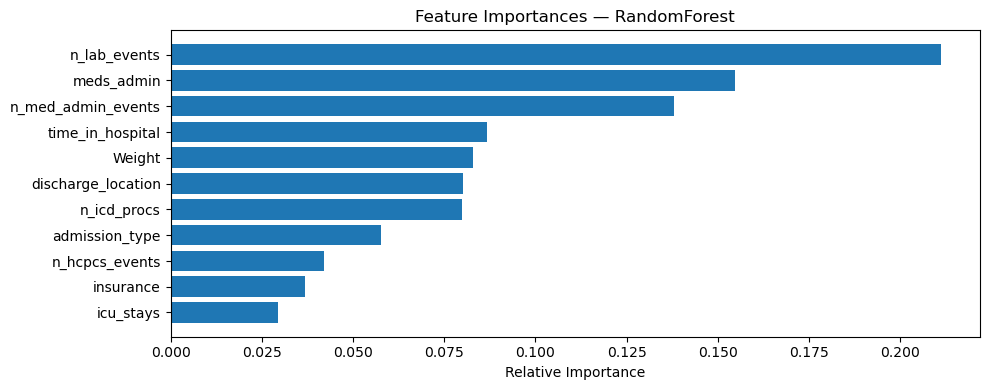

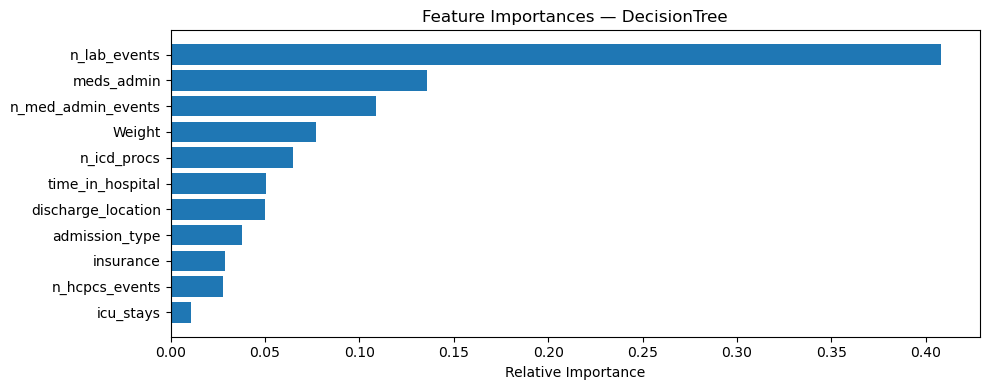

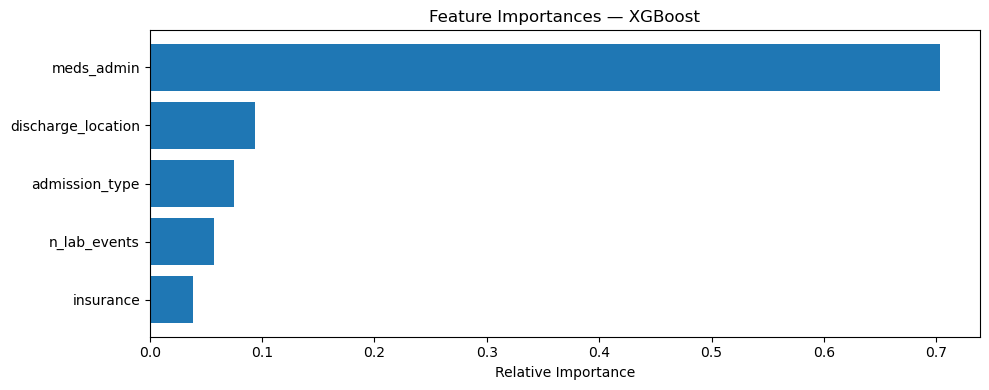

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# build raw importances dict
raw_imps = {}
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        raw_imps[name] = model.feature_importances_
    elif hasattr(model, "coef_"):
        raw_imps[name] = np.abs(model.coef_[0])

# get the transformer output names
all_feats = preprocessor.get_feature_names_out()  # e.g. ["num__n_lab_events", "cat__insurance_Medicare", ...]

# strip prefixes
# numeric => "num__X", cat => "cat__var_value"
num_prefix, cat_prefix = "num__", "cat__"

for model_name, imps in raw_imps.items():
    agg = {}
    # first, numeric features
    for i, feat in enumerate(all_feats):
        if feat.startswith(num_prefix):
            orig = feat.split(num_prefix, 1)[1]
            agg[orig] = imps[i]

    # now, categorical: sum dummies
    for cat in cat_features:
        mask = [f.startswith(f"{cat_prefix}{cat}_") for f in all_feats]
        total = imps[np.array(mask)].sum()
        agg[cat] = total

    # filter and sort
    threshold = 0.01
    items = [(k, v) for k, v in agg.items() if v > threshold]
    if not items:
        continue
    items.sort(key=lambda x: x[1], reverse=True)
    names, vals = zip(*items)

    # plot
    fig, ax = plt.subplots(figsize=(10, max(4, len(names)*0.3)))
    y_pos = np.arange(len(names))
    ax.barh(y_pos, vals, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names, fontsize=10)
    ax.invert_yaxis()
    ax.set_title(f"Feature Importances — {model_name}")
    ax.set_xlabel("Relative Importance")
    plt.tight_layout()
    plt.show()


In [97]:
# Create a new DataFrame combining df_unique with Predictions and Probability
df_predictions = df_unique.copy()

# Prepare the feature matrix exactly as in training
X_full = df_predictions[num_features + cat_features]
X_full_proc = preprocessor.transform(X_full)

# Generate positive-class probabilities and thresholded predictions
proba_full = best_xgb.predict_proba(X_full_proc)[:, 1]
preds_full = (proba_full >= best_thr).astype(int)

# Add the two new columns
df_predictions["Predictions"] = preds_full
df_predictions["Probability"]  = proba_full

# Inspect the result
print(df_predictions[["Predictions", "Probability"]].head())


   Predictions  Probability
0            0     0.769373
1            0     0.285409
2            0     0.079621
3            0     0.297883
4            0     0.586350


In [ ]:
from pathlib import Path

output_path = Path(r"Local_folder") / "df_predictions.csv"

df_predictions.to_csv(output_path, index=False)

print(f"Saved DataFrame to: {output_path}")